In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%config Completer.use_jedi = False

In [2]:
from datasets import InsectImgDataset
from utils import *
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A

from torchvision import datasets, transforms
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.utils import class_weight

setting = 'fuji'
if setting == 'photobox':
    ext = '.png'
elif setting == 'fuji':
    ext = '.jpg'

Available workers: 16


In [3]:
dfs = InsectImgDataset(ext=ext, setting=setting, directory=DATA_DIR)
dfs.extract_df_info()
df = dfs.df

Extracting info from filenames..: 100%|██████████| 67841/67841 [00:09<00:00, 7057.34it/s]


# Creating train,val,test sets

## Removing outliers

In [4]:
df_pre = pd.read_parquet(f"{SAVE_DIR}/df_preparation_{setting}.parquet")
df = pd.merge(df,df_pre, on=['filename','label','platename','imgname','date','year','plate_idx','location','xtra'])
df = df[df.knn_outlier==0]
df = df[df.nb_contours>0]
df = df[~df['label'].isin(['st','vuil'])]
df.label = df.label.apply(lambda x: 'v' if x=='v(cy)' else x)

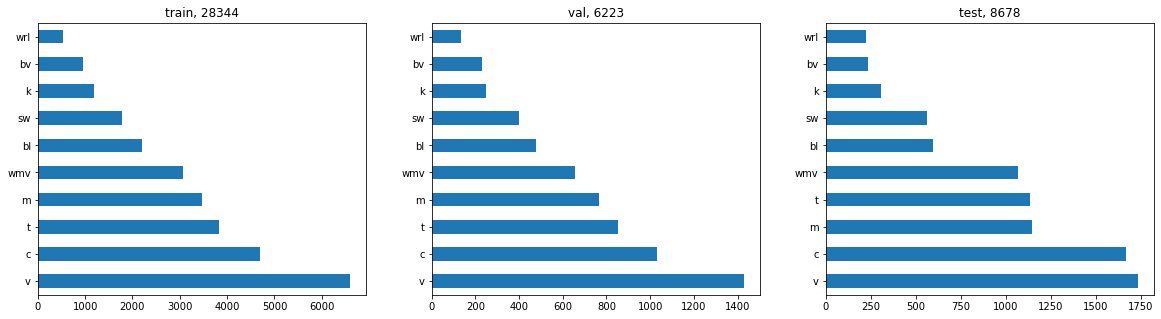

In [5]:
test_plates = train_test_split(df.platename.unique(), random_state=2022, test_size=0.2, shuffle=True)[1].tolist()
testseries = pd.Series(test_plates)
inds = testseries.apply(lambda x: 'wortel' in x)
inds = testseries[inds].sample(10).index.values
wortel_plates = testseries[inds].tolist()
test_plates = testseries[testseries.apply(lambda x: x.split('_')[1] != 'wortel')].tolist() + wortel_plates

df_trainval = df[~df.platename.isin(test_plates)]
df_test = df[df.platename.isin(test_plates)]

topclasses = df['label'].value_counts().head(10).index.tolist()

df = df[df['label'].isin(topclasses)]
df_trainval = df_trainval[df_trainval['label'].isin(topclasses)]
df_test = df_test[df_test['label'].isin(topclasses)]

class_weights = class_weight.compute_class_weight('balanced', 
                                                  classes=np.unique(df['label'].tolist()), 
                                                  y=df['label'].tolist())

class_weights = {np.unique(df['label'])[i]:class_weights[i] for i in range(len(class_weights))}
df['weights'] = df['label'].map(class_weights)

df_train, df_val = train_test_split(df_trainval, test_size=0.18, random_state=42, shuffle=True)

le = LabelEncoder()
le.fit(df_train.label)

plt.figure(figsize=(20,5))
plt.subplot(1,3,1);df_train.label.value_counts().plot(kind='barh');plt.title(f'train, {df_train.shape[0]}')
plt.subplot(1,3,2);df_val.label.value_counts().plot(kind='barh');plt.title(f'val, {df_val.shape[0]}')
plt.subplot(1,3,3);df_test.label.value_counts().plot(kind='barh');plt.title(f'test, {df_test.shape[0]}');

In [6]:
assert len(set(df_train.filename.tolist()).intersection(df_test.filename.tolist())) == 0
assert len(set(df_train.filename.tolist()).intersection(df_val.filename.tolist())) == 0

# Creating Pytorch Datasets and Dataloaders

In [7]:
transforms_list_train = [
#     A.SmallestMaxSize(max_size=150),
#     A.Resize(height=150,width=150,p=1),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225], p=1, always_apply=True),
    A.ShiftScaleRotate(shift_limit=0.01,rotate_limit=45, scale_limit=0, p=.5),
    A.Rotate(limit=90, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    # A.RandomGamma(p=0.5),
     A.RandomBrightnessContrast(p=0.2),
     A.GaussianBlur(blur_limit=(3,3), p=0.1)
]

transforms_list_test = [
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225], 
                p=1, 
                always_apply=True)
]

train_dataset = InsectImgDataset(df=df_train.reset_index(drop=True), transform=A.Compose(transforms_list_train))
valid_dataset = InsectImgDataset(df=df_val.reset_index(drop=True), transform=A.Compose(transforms_list_test))
test_dataset = InsectImgDataset(df=df_test.reset_index(drop=True), transform=A.Compose(transforms_list_test))

batch_size = 32
batch_size_val = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

# plt.imshow(train_dataset[0][0]); plt.title(f"Example train image, class:{train_dataset[0][1]}");

# Defining the model and training parameters

In [8]:
torch.backends.cudnn.benchmark = True

In [9]:
modelname = "densenet121"
model = model_selector(modelname, pretrained=True)
try:
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs,len(topclasses))
except:
    pass
try:
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs,len(topclasses))
except:
    pass
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

num_epochs = 50

class_sample_count = np.unique(df_train.label, return_counts=True)[1]
weight = 1. / class_sample_count  
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weight).cuda())

Train on gpu: True


In [55]:
optimizer = optim.Adam(model.parameters(), lr=.001)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, cycle_momentum=False, mode="triangular2")

In [56]:
#optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3, amsgrad=True)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, cycle_momentum=False, mode="triangular2")

# Training

In [57]:
results = {"loss":[], "val_loss":[], "train_accuracy":[], "valid_accuracy":[]}
best_valacc = 0
# Model training
for epoch in range(num_epochs):
    # Going through the training set
    correct_train = 0
    model.train()
    for x_batch,y_batch,imgname,platename,filename,plate_idx,location,date,year,xtra,width,height in tqdm(train_dataloader, desc='Training..\t'):        
        y_batch = torch.as_tensor(le.transform(y_batch))#.type(torch.LongTensor)
        x_batch,y_batch = x_batch.float().cuda(), y_batch.cuda()
        for param in model.parameters():
            param.grad = None
        pred = model(x_batch)

        y_batch = y_batch.type(torch.LongTensor).cuda()
        correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
    train_accuracy = correct_train / len(train_dataset) * 100.
    
    # Going through the validation set
    correct_valid = 0
    model.eval()
    for x_batch,y_batch,imgname,platename,filename,plate_idx,location,date,year,xtra,width,height in tqdm(valid_dataloader, desc='Validating..\t'):
        y_batch = torch.as_tensor(le.transform(y_batch))#.type(torch.LongTensor)
        x_batch,y_batch = x_batch.float().cuda(), y_batch.cuda()
        pred = model(x_batch)

        y_batch = y_batch.type(torch.LongTensor).cuda()
        correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
        val_loss = criterion(pred, y_batch)
    valid_accuracy = correct_valid / len(valid_dataset) * 100.

    scheduler.step()
#     early_stopping(val_loss, model)
#     if early_stopping.early_stop:
#         print("Early stopping")
#         break

        # Printing results
    print(f"Epoch {epoch}: train_acc: {train_accuracy:.1f}% loss: {loss:.7f},  val_loss: {val_loss:.7f} val_acc: {valid_accuracy:.1f}%")
        
    is_best = valid_accuracy > best_valacc
    if is_best:
        print(f"Validation accuracy improved from {best_valacc:.2f} to {valid_accuracy:.2f}. Saving model..")
    best_valacc = max(valid_accuracy, best_valacc)
    save_checkpoint({
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'best_valacc': best_valacc,
        'loss': results['loss'].append(loss.detach().cpu()),
        'val_loss': results['val_loss'].append(val_loss.detach().cpu()),
        'train_accuracy': results['train_accuracy'].append(train_accuracy),
        'valid_accuracy': results['valid_accuracy'].append(valid_accuracy),
        'optimizer' : optimizer.state_dict(),
    }, is_best, f"{modelname}_{setting}")


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 25.08it/s]


Epoch 0: train_acc: 66.6% loss: 0.4318833,  val_loss: 0.7225544 val_acc: 75.3%
Validation accuracy improved from 0.00 to 75.25. Saving model..


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.71it/s]


Epoch 1: train_acc: 74.9% loss: 1.0076646,  val_loss: 1.0404285 val_acc: 79.2%
Validation accuracy improved from 75.25 to 79.24. Saving model..


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.75it/s]


Epoch 2: train_acc: 77.1% loss: 0.4449868,  val_loss: 0.9189702 val_acc: 81.6%
Validation accuracy improved from 79.24 to 81.60. Saving model..


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.68it/s]


Epoch 3: train_acc: 78.3% loss: 0.6003480,  val_loss: 1.1241573 val_acc: 79.9%


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.53it/s]


Epoch 4: train_acc: 79.0% loss: 0.4494151,  val_loss: 0.7853395 val_acc: 79.3%


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.55it/s]


Epoch 5: train_acc: 79.5% loss: 0.5288391,  val_loss: 1.1815410 val_acc: 81.7%
Validation accuracy improved from 81.60 to 81.66. Saving model..


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.49it/s]


Epoch 6: train_acc: 80.0% loss: 0.4556445,  val_loss: 0.9729115 val_acc: 81.3%


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.62it/s]


Epoch 7: train_acc: 80.4% loss: 0.3308048,  val_loss: 0.8535368 val_acc: 82.8%
Validation accuracy improved from 81.66 to 82.84. Saving model..


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.58it/s]


Epoch 8: train_acc: 80.8% loss: 0.1702431,  val_loss: 0.9262734 val_acc: 82.2%


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.15it/s]


Epoch 9: train_acc: 81.3% loss: 0.4019126,  val_loss: 1.2380747 val_acc: 83.4%
Validation accuracy improved from 82.84 to 83.45. Saving model..


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.22it/s]


Epoch 10: train_acc: 81.5% loss: 0.2252885,  val_loss: 1.0815934 val_acc: 83.1%


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.64it/s]


Epoch 11: train_acc: 81.9% loss: 0.6100410,  val_loss: 0.9738610 val_acc: 83.5%
Validation accuracy improved from 83.45 to 83.50. Saving model..


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.67it/s]


Epoch 12: train_acc: 81.8% loss: 0.2551393,  val_loss: 0.9658522 val_acc: 80.7%


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.58it/s]


Epoch 13: train_acc: 82.3% loss: 0.2738634,  val_loss: 0.9103787 val_acc: 82.5%


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.67it/s]


Epoch 14: train_acc: 82.6% loss: 0.5761556,  val_loss: 1.0275760 val_acc: 82.0%


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.73it/s]


Epoch 15: train_acc: 82.6% loss: 0.5223772,  val_loss: 1.0444511 val_acc: 82.8%


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.78it/s]


Epoch 16: train_acc: 82.9% loss: 0.4945675,  val_loss: 0.9846647 val_acc: 83.4%


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.67it/s]


Epoch 17: train_acc: 83.3% loss: 0.6813726,  val_loss: 0.9633948 val_acc: 83.6%
Validation accuracy improved from 83.50 to 83.56. Saving model..


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.72it/s]


Epoch 18: train_acc: 82.9% loss: 0.3477430,  val_loss: 1.0345953 val_acc: 83.8%
Validation accuracy improved from 83.56 to 83.77. Saving model..


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.81it/s]


Epoch 19: train_acc: 83.7% loss: 0.2822069,  val_loss: 0.9928275 val_acc: 82.8%


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.81it/s]


Epoch 20: train_acc: 83.6% loss: 0.1855593,  val_loss: 0.9319707 val_acc: 81.4%


Validating..	: 100%|██████████| 195/195 [00:06<00:00, 27.94it/s]


Epoch 21: train_acc: 83.6% loss: 0.4489720,  val_loss: 0.9703467 val_acc: 82.0%


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.78it/s]


Epoch 22: train_acc: 83.5% loss: 0.3226572,  val_loss: 1.0993682 val_acc: 83.0%


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.74it/s]


Epoch 23: train_acc: 84.2% loss: 0.7868232,  val_loss: 1.1907160 val_acc: 82.7%


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.62it/s]


Epoch 24: train_acc: 84.3% loss: 0.2377622,  val_loss: 1.0878478 val_acc: 83.7%


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.86it/s]


Epoch 25: train_acc: 84.5% loss: 0.3518203,  val_loss: 0.8653550 val_acc: 83.7%


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.51it/s]


Epoch 26: train_acc: 84.4% loss: 0.4754623,  val_loss: 1.3535534 val_acc: 84.2%
Validation accuracy improved from 83.77 to 84.17. Saving model..


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.75it/s]


Epoch 27: train_acc: 84.9% loss: 0.3140724,  val_loss: 1.1654922 val_acc: 83.7%


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.70it/s]


Epoch 28: train_acc: 85.2% loss: 0.4289881,  val_loss: 1.2401690 val_acc: 83.1%


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.65it/s]


Epoch 29: train_acc: 85.4% loss: 0.3038255,  val_loss: 1.1198983 val_acc: 83.4%


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.74it/s]


Epoch 30: train_acc: 85.2% loss: 0.1591282,  val_loss: 1.1751963 val_acc: 83.1%


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.57it/s]


Epoch 31: train_acc: 85.1% loss: 0.3552686,  val_loss: 1.3341429 val_acc: 84.0%


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.60it/s]


Epoch 32: train_acc: 85.6% loss: 0.3493392,  val_loss: 1.5954860 val_acc: 82.5%


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.06it/s]


Epoch 33: train_acc: 85.2% loss: 0.3731120,  val_loss: 1.9714326 val_acc: 82.0%


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.06it/s]


Epoch 34: train_acc: 85.8% loss: 0.2389080,  val_loss: 2.0130739 val_acc: 82.9%


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.14it/s]


Epoch 35: train_acc: 85.8% loss: 0.3929743,  val_loss: 0.9789816 val_acc: 83.9%


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 27.07it/s]


Epoch 36: train_acc: 85.9% loss: 1.0786091,  val_loss: 1.6956897 val_acc: 83.1%


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 26.89it/s]


Epoch 37: train_acc: 85.9% loss: 0.8232835,  val_loss: 1.2603359 val_acc: 82.6%


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 26.64it/s]


Epoch 38: train_acc: 86.0% loss: 0.3849578,  val_loss: 0.9494644 val_acc: 83.7%


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 25.76it/s]


Epoch 39: train_acc: 87.1% loss: 0.3359847,  val_loss: 0.9839286 val_acc: 82.4%


Validating..	: 100%|██████████| 195/195 [00:07<00:00, 26.33it/s]


Epoch 40: train_acc: 86.5% loss: 0.6617618,  val_loss: 1.9878068 val_acc: 82.2%


Training..	:   4%|▍         | 38/886 [00:05<01:53,  7.46it/s]


KeyboardInterrupt: 